<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>
<font size="4"><center> <b> Example 5a - Beachface Cluster Dynamics indices - location level </b></center> <br>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">
<br>
<font size="5"> <b>Location scale beachface behavioural modelling</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<font size="3">These indices represents the tendency of the location, or transect, to either erode or accrete, based on the temporal succession of sand-only change. <br>

<b>This notebook covers the following concepts:</b>

- Modelling BCDs at the location scale.
- Plotting.
</font>


</font>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sandpyper.outils import getLoc, getDate,coords_to_points
from sandpyper.dynamics import  BCDs_compute, steady_state_transect, compute_rBCD_transects, infer_weights

crs_dict_string={"mar":{'init': 'epsg:32754'},
         "leo":{'init': 'epsg:32755'}}

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


We use the __hotspot sand-only beachface points__ that have been previously classified into dh magnitude classes (transient states)

In [2]:
in_file=r"C:\my_packages\doc_data\markov_tagged\markov_tagged_df.csv"
dataset=pd.read_csv(in_file)

dataset["coordinates"]=dataset.geometry.apply(coords_to_points)
dataset_gdf=gpd.GeoDataFrame(dataset, geometry="coordinates",crs=crs_dict_string['mar'])
dataset_gdf.sort_values(['date_pre'], inplace=True)

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## class

In [250]:
from tqdm.notebook import tqdm
import pandas as pd
from shapely.geometry import Point
from shapely import wkt
import geopandas as gpd
import numpy as np
from pysal.lib import weights
import pysal.explore.esda.moran as moran
from pysal.explore.esda.util import fdr
from sandpyper.outils import coords_to_points
from itertools import product as prod
from pysal.viz.mapclassify import (EqualInterval,
                                   FisherJenks,
                                   HeadTailBreaks,
                                   JenksCaspall,
                                   KClassifiers,
                                   Quantiles,
                                   Percentiles,
                                   UserDefined)
class Discretiser:
    """
    Create a Discretiser instance that classify a numeric field of a dataframe (with its fit method) into bins, using a specific method.

    Args:
        bins (list, int or None): If a list is provided, use those as break points to discretise the data.
        If an integer is provided, this defines the desired number of bins. If None (Default), it automatically finds the best number of bins.
        method (str): Name of the discretisation method to use, as specified by Pysal. Must be one of:

        EqualInterval
        FisherJenks
        HeadTailBreaks
        JenksCaspall
        KClassifiers
        Quantiles
        Percentiles

        Please visit Pysal documentation for more information :
        https://pysal.org/notebooks/viz/mapclassify/intro.html#Map-Classifiers-Supported

    returns:
        Discretiser class.
    """

    dict_classifiers={'EqualInterval':EqualInterval,
     'FisherJenks':FisherJenks,
     'HeadTailBreaks':HeadTailBreaks,
     'JenksCaspall':JenksCaspall,
     'KClassifiers':KClassifiers,
     'Quantiles':Quantiles,
     'Percentiles':Percentiles,
     'UserDefined':UserDefined}

    def __init__(self, bins, method, labels=None):

        if method not in self.dict_classifiers.keys():
            raise NameError(f"{method} not a valid method name. Supported method in this docstring.")

        # Check that bins is valid list, integer or None
        if isinstance(bins, list):
            if len(bins) <= 1:
                raise ValueError("The list provided cannot have zero or only one break point!")
            else:
                if method == 'Percentiles':
                    if min(bins) < 0 or max(bins) > 100:
                        raise ValueError("When using precentiles as break points, the provided list must be in the range [0, 100].")
                    else:
                        print(f"Data will be partitioned using user-provided percentiles.")
                        bins_size=len(bins)
                else:
                    print(f"Data will be partitioned using user-provided bins.")
                    bins_size=len(bins)

        elif isinstance(bins, int):
            if bins<=1:
                raise ValueError("The number of bins to use cannot be zero, one or negative!")
            else:
                print(f"Data will be partitioned into {bins} discrete classes.")
                bins_size=bins

        elif bins==None:
            print("Automatic discretisation will be performed. This method is time consuming with large datasets.")
        else:
            raise ValueError("The bins parameter is not understood. Must be either a list, integer or None.")

        if labels != None:
            if len(labels)!=bins_size:
                raise ValueError("The number of labels doesn't match the provided bins. They must be the same. Alternatively, set labels=None to not use labels.")
            else:
                print("Labels provided.")


        self.bins=bins
        self.method=method
        self.labels=labels
        self.bins_size=bins_size



    def fit(self, df, absolute = True, field="dh", appendix = ("_deposition","_erosion"), print_summary=False):
        """
        Fit discretiser to the dataframe containing the field of interest.

        Args:
            df (Pandas DataFrame): Dataframe with colum to discretise.
            absolute (bool): wether to discretise the absolute values of the data or not. If True (default), the bins will
            be derived from absolute values, then, classes will be assigned to both negative and positive numbers accordingly.
            field (str): Name of the column with data to discretise. Data must be numeric.
            appendix (tuple): String to append at the end of each label when absolute is True. Defaults = ("_deposition","_erosion").

        returns:
            Input dataframe with added columns containing the bins and a column with the labels (if provided).
        """

        if absolute:
            data_ero=df[df.loc[:,field] < 0]
            data_depo=df[df.loc[:,field] > 0]
            data=np.abs(df.loc[:,field])
        else:
            data=df.loc[:,field]

        bins_discretiser=self.dict_classifiers[self.method](data, self.bins)
        if print_summary==True:
            print(bins_discretiser)
        print(f"\nFit of {self.method} with {self.bins} bins: {bins_discretiser.adcm}")

        bins_depo = list(bins_discretiser.bins[:-1])
        bins_ero = list(np.flip(bins_discretiser.bins[:-1]) * -1)

        bins_ero_JC = UserDefined(data_ero.loc[:,field], bins_ero)
        bins_depo_JC = UserDefined(data_depo.loc[:,field], bins_depo)

        class_erosion=bins_ero_JC.yb.tolist()
        class_deposition=bins_depo_JC.yb.tolist()

        if self.labels == None:
            self.labels=[f"bin_{str(i)}" for i in range(0,self.bins_size)]

        # create dictionaries where keys are the bin number assigned by discretiser and value is the label
        depo_class_names=[i[0]+i[1] for i in list(prod(self.labels,[appendix[0]]))]
        ero_class_names=[i[0]+i[1] for i in list(prod(self.labels,[appendix[1]]))]
        
        # a general list of tags
        self.tags=[i[0]+i[1] for i in list(prod(self.labels,appendix))]
        reverse_tags=list(reversed(self.tags))
        self.tags_order=[reverse_tags[i] for i in range(1,len(reverse_tags),2)]+[self.tags[i] for i in range(1,len(self.tags),2)]

        states_depo={yb:class_name for yb,class_name in enumerate(depo_class_names)}
        states_ero={yb*-1:class_name for yb,class_name in enumerate(ero_class_names, start=-len(ero_class_names)+1)}

        data_ero["markov_tag"]=[states_ero[i] for i in class_erosion]
        data_depo["markov_tag"]=[states_depo[i] for i in class_deposition]

        self.df_labelled= pd.concat([data_ero,data_depo],ignore_index=False)        
        
    def infer_weights(self, markov_tag_field="markov_tag"):
        """Compute weights from dataset with markov labels to use for e-BCDs computation.
            The medians of each magnitude class will be used as weight.

        Args:
            data (Pandas Dataframe): Pandas dataframe.
            markov_tag_field (str): Name of the column where markov tags are stored.

        Returns:
            dict, containing the markov tags and associated weights.
        """
        joined_re = r"|".join(self.labels)
        self.df_labelled["magnitude_class"] = [re.findall(joined_re,tag)[0] for tag in self.df_labelled.loc[:,markov_tag_field]]

        # create a dictionary with all the medians of the magnitude classes
        class_abs_medians=dict(self.df_labelled.groupby(["magnitude_class"]).dh.apply(lambda x : np.round(np.median(np.abs(x)),2)))

        # create a dictionary with all the weights in each tag
        self.weights_dict={tag:class_abs_medians[re.findall(joined_re,tag)[0]] for tag in self.tags}

In [7]:
from sandpyper.hotspot import LISA_site_level, Discretiser  
dh_file_path=r"C:\my_packages\sandpyper\tests\test_outputs\dh_data.csv"
df_multitemp=pd.read_csv(dh_file_path)
crs_dict_string={"mar":{'init': 'epsg:32754'},
         "leo":{'init': 'epsg:32755'}}
distance_value=35 #enough to include two adjacent transect and some obliques without getting to the second transect
k_value=0
mode="distance" #select from "knn", "idw" or "distance"

lisa_df=LISA_site_level(dh_df=df_multitemp,
                        mode=mode,
                        distance_value=35,
                        geometry_column="geometry",
                        crs_dict_string=crs_dict_string)

lisa_df.tail()

  0%|          | 0/2 [00:00<?, ?it/s]

Working on mar


C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0/8 [00:00<?, ?it/s]

Working on leo


C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


  0%|          | 0/5 [00:00<?, ?it/s]

,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh,lisa_fdr,lisa_q,lisa_I,lisa_n_val_obs,lisa_opt_dist,lisa_dist_mode,lisa_p_sim,lisa_z_sim,lisa_z,decay
19862,POINT (300071.060 5773184.013),leo,18,48.0,dt_0,20180606,20180713,-0.435838,-0.624926,-0.189088,0.008667,2,-0.031762,1448,35,distance_band,0.220,-0.662466,-0.419606,0
19863,POINT (300072.023 5773184.284),leo,18,49.0,dt_0,20180606,20180713,-0.431080,-0.642019,-0.210939,0.008667,2,-0.035211,1448,35,distance_band,0.226,-0.614807,-0.461142,0
19864,POINT (300075.506 5773164.488),leo,17,47.0,dt_0,20180606,20180713,-0.316839,-0.478775,-0.161936,0.008667,3,0.010098,1448,35,distance_band,0.472,0.152752,-0.367991,0
19865,POINT (300076.469 5773164.759),leo,17,48.0,dt_0,20180606,20180713,-0.459795,-0.477090,-0.017296,0.008667,3,0.001456,1448,35,distance_band,0.483,0.040146,-0.093039,0
19866,POINT (300077.432 5773165.029),leo,17,49.0,dt_0,20180606,20180713,-0.557283,-0.493576,0.063707,0.008667,4,-0.000800,1448,35,distance_band,0.500,-0.094958,0.060942,0


In [310]:
labels=["Undefined", "Small", "Medium", "High", "Extreme"]
appendix=["_deposition", "_erosion"]
D = Discretiser(bins=5, method="JenksCaspall", labels=labels)

D.fit(lisa_df, absolute=True, print_summary=True)
D.infer_weights()
D.weights_dict

Data will be partitioned into 5 discrete classes.
Labels provided.
              JenksCaspall              
 
Lower          Upper               Count
        x[i] <= 0.111               8050
0.111 < x[i] <= 0.274               5404
0.274 < x[i] <= 0.533               3634
0.533 < x[i] <= 1.213               2332
1.213 < x[i] <= 8.464                447

Fit of JenksCaspall with 5 bins: 1280.1102305326785


{'Undefined_deposition': 0.05,
 'Undefined_erosion': 0.05,
 'Small_deposition': 0.18,
 'Small_erosion': 0.18,
 'Medium_deposition': 0.37,
 'Medium_erosion': 0.37,
 'High_deposition': 0.7,
 'High_erosion': 0.7,
 'Extreme_deposition': 1.73,
 'Extreme_erosion': 1.73}

In [322]:
loc='mar'
dataset=D.df_labelled
weights_dict=D.weights_dict
mode='all'
unique_field="geometry"
label_order=D.tags_order
store_neg=True
plot_it=True
fig_size=(6, 4)
heat_annot_size=10
font_scale=0.75
dpi=300
save_it=False

In [323]:
import shapely
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import itertools
from itertools import product, combinations

from pysal.explore.giddy.markov import Markov
import matplotlib.pyplot as plt
import seaborn as sb

from sandpyper.outils import getListOfFiles, getLoc, create_spatial_id

def get_coastal_Markov(arr_markov, weights_dict, store_neg=True):
    """Compute BCDs from first-order transition matrices of dh magnitude classes (as states).

    Args:
        arr_markov (array): Numpy array of markov transition matrix.
        weights_dict (dict): Dictionary with keys:dh classes, values: weigth (int). Especially useful for the e-BCDs magnitude trend (sign).
        store_neg: If True (default), use the subtraction for diminishing trends.

    Returns:
        BCD index, value of the trend, the sign ('-' or '+') for plotting purposes.
    """

    combs = pd.Series(product(arr_markov.index, (arr_markov.columns)))

    value_trans = 0
    value_trend = 0

    for state1, state2 in combs:

        state_1_w = weights_dict[state1]  # extract the weights
        state_2_w = weights_dict[state2]
        value = arr_markov.at[state1, state2]

        if state_1_w > state_2_w:  # check if the change is decr

            if bool(store_neg):
                weigth_adhoc = state_1_w * state_2_w
                weigth_adhoc_trend = state_1_w * (-(state_2_w))

            else:
                weigth_adhoc = state_1_w * ((state_2_w))

            value_trans += value
            value_trend += value * weigth_adhoc_trend

        elif state_1_w < state_2_w:
            weigth_adhoc_trend = state_1_w * state_2_w

            value_trans += value
            value_trend += value * weigth_adhoc_trend

        else:
            weigth_adhoc_trend = state_1_w * state_2_w

            value_trans += value
            value_trend += value * weigth_adhoc_trend

    if value_trend > 0:
        sign = "+"
    elif value_trend < 0:
        sign = "-"
    elif value_trend == 0:
        sign = "0"
    else:
        sign = np.nan

    return np.round(value_trans, 3), np.round(value_trend, 3), sign

In [324]:
D.tags_order

['Extreme_deposition',
 'High_deposition',
 'Medium_deposition',
 'Small_deposition',
 'Undefined_deposition',
 'nnn',
 'Undefined_erosion',
 'Small_erosion',
 'Medium_erosion',
 'High_erosion',
 'Extreme_erosion']

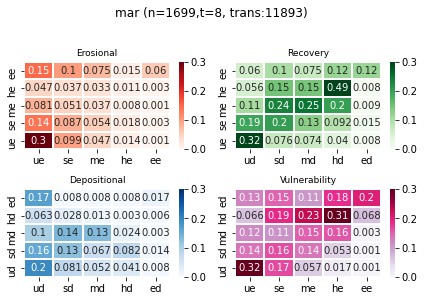

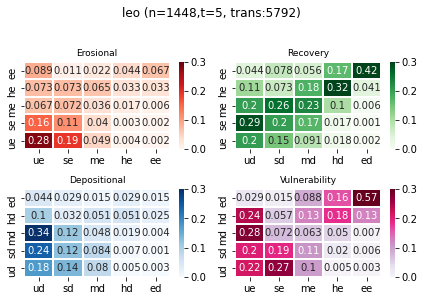

In [338]:
sb.set_context(font_scale=font_scale)

    
steady_state_victoria = pd.DataFrame()
markov_indexes_victoria = pd.DataFrame()

for loc in dataset.location.unique():

    if "nnn" not in label_order:
        label_order.insert(len(D.tags)//2,"nnn")

    if isinstance(dataset.loc[0,unique_field], shapely.geometry.point.Point):
        dataset['spatial_id']=dataset.loc[:,unique_field].apply(str)
        unique_field='spatial_id'
    else:
        pass

    dataset_piv = dataset.query(f"location=='{loc}'").pivot(
        values="markov_tag", index=unique_field, columns="dt"
    )

    if mode == "all":
        dataset_piv.fillna("nnn", inplace=True)

    elif mode == "drop":
        dataset_piv.dropna(axis="index", how="any", inplace=True)

    elif isinstance(mode, float):

        dts = len(dataset_piv.columns)
        thrsh = int(mode * dts)

        dataset_piv.dropna(axis=0, how="any", thresh=7, inplace=True)
        dataset_piv.fillna("nnn", inplace=True)

    else:
        raise NameError(
            " Specify the mode ('drop', 'all', or a float number (0.5,1.0,0.95)"
        )

    n = dataset_piv.shape[0]
    t = dataset_piv.shape[1]

    arr = np.array(dataset_piv)

    m = Markov(arr)
    n_transitions = m.transitions.sum().sum()

    steady_state = pd.DataFrame(m.steady_state, index=m.classes, columns=[loc])
    steady_state_victoria = pd.concat([steady_state, steady_state_victoria], axis=1)

    markov_df = pd.DataFrame(np.round(m.p, 3), index=m.classes, columns=m.classes)

    # if any column is missing from label_order, then add both row and column
    # and populate with zeroes
    if markov_df.columns.all != len(labels)+1:  # plus nnn
        # which one is missing?
        missing_states = [
            state for state in label_order if state not in markov_df.columns
        ]
        for (
            miss
        ) in missing_states:  # for all missing states, add columns with zeroes
            markov_df[f"{miss}"] = float(0)
            # # at the end of the (squared) dataframe
            last_idx = markov_df.shape[0]
            markov_df.loc[last_idx + 1] = [float(0) for i in markov_df.columns]

        # get a list of str of the missing states
        to_rename = markov_df.index.to_list()[-len(missing_states) :]
        for i, j in zip(to_rename, missing_states):
            markov_df.rename({i: j}, inplace=True)

    markov_ordered = markov_df.loc[label_order, label_order]

    # When no transition occurred, replace NaN with a 0.
    markov_ordered.fillna(0, inplace=True)

    idx_matrix=len(D.tags)//2

    dd = markov_ordered.iloc[:idx_matrix, :idx_matrix]
    dd = dd[dd.columns[::-1]]

    ee = markov_ordered.iloc[idx_matrix+1:, idx_matrix+1:]
    ee = ee.reindex(index=ee.index[::-1])

    de = markov_ordered.iloc[:idx_matrix, idx_matrix+1:]

    ed = markov_ordered.iloc[idx_matrix+1:, :idx_matrix]
    ed = ed.reindex(index=ed.index[::-1])
    ed = ed[ed.columns[::-1]]

    list_markovs = [ee, ed, dd, de]
    dict_markovs = {"ee": ee, "ed": ed, "dd": dd, "de": de}


    # create index dataframe

    for arr_markov in dict_markovs.keys():

        idx, trend, sign = get_coastal_Markov(
            dict_markovs[arr_markov], weights_dict=weights_dict, store_neg=store_neg
        )

        idx_coastal_markov_dict = {
            "location": loc,
            "sub_matrix": arr_markov,
            "coastal_markov_idx": idx,
            "trend": trend,
            "sign": sign,
        }

        idx_coastal_markov_df = pd.DataFrame(idx_coastal_markov_dict, index=[0])
        markov_indexes_victoria = pd.concat(
            [idx_coastal_markov_df, markov_indexes_victoria], ignore_index=True
        )
        
    if bool(plot_it):

        titles = ["Erosional", "Recovery", "Depositional", "Vulnerability"]
        cmaps = ["Reds", "Greens", "Blues", "PuRd"]

        std_excluding_nnn = (
            markov_ordered.loc[
                markov_ordered.index != "nnn", markov_ordered.columns != "nnn"
            ]
            .values.flatten()
            .std()
        )
        exclude_outliers = np.round(3 * std_excluding_nnn, 1)

        f2, axs = plt.subplots(nrows=2, ncols=2, figsize=fig_size)

        for ax_i, heat, title, cmap_i in zip(
            axs.flatten(), list_markovs, titles, cmaps
        ):
            sb.heatmap(
                heat.rename(columns=relabel_dict, index=relabel_dict),
                cmap=cmap_i,
                annot=True,
                linewidths=1,
                linecolor="white",
                vmin=0,
                vmax=exclude_outliers,
                annot_kws={"size": heat_annot_size},
                ax=ax_i,
            )
            ax_i.set_title(f"{title}", size=9)
            title = f2.suptitle(f"{loc} (n={n},t={t}, trans:{int(n_transitions)}) ")
            title.set_position([0.5, 1.03])
            f2.tight_layout(pad=1)

        if bool(save_it):
            f2.savefig(f"{save_output}{loc}_sub_matrices_.png", dpi=dpi)
        else:
            pass
    else:
        pass


In [333]:
list_markovs[1]

,Undefined_deposition,Small_deposition,Medium_deposition,High_deposition,Extreme_deposition
Extreme_erosion,0.044,0.078,0.056,0.167,0.422
High_erosion,0.114,0.073,0.179,0.317,0.041
Medium_erosion,0.203,0.258,0.231,0.103,0.006
Small_erosion,0.289,0.203,0.172,0.017,0.001
Undefined_erosion,0.205,0.147,0.091,0.018,0.002


In [334]:
relabel_dict={"Undefined_erosion":"ue",
"Small_erosion":"se",
"Medium_erosion":"me",
"High_erosion":"he",
"Extreme_erosion":"ee",
 "Undefined_deposition":"ud",
 "Small_deposition":"sd",
 "Medium_deposition":"md",
 "High_deposition":"hd",
 "Extreme_deposition":"ed"
}

In [336]:
print(list_markovs[1].rename(columns=relabel_dict, index=relabel_dict))

       ud     sd     md     hd     ed
ee  0.044  0.078  0.056  0.167  0.422
he  0.114  0.073  0.179  0.317  0.041
me  0.203  0.258  0.231  0.103  0.006
se  0.289  0.203  0.172  0.017  0.001
ue  0.205  0.147  0.091  0.018  0.002


In [ ]:
titles=["Erosional", "Recovery", "Depositional","Vulnerability"]

translation=dict(zip(["ee","ed","dd","de"],titles))
e_bcds["states_labels"]=e_bcds["sub_matrix"].map(translation)

In [329]:
steady_state_victoria

,leo,mar
Extreme_deposition,0.010253,0.007918
Extreme_erosion,0.014815,0.008950
High_deposition,0.029028,0.084221
High_erosion,0.020230,0.055861
Medium_deposition,0.105407,0.079774
Medium_erosion,0.074111,0.070229
Small_deposition,0.148019,0.097382
Small_erosion,0.163284,0.092474
Undefined_deposition,0.222089,0.129175
Undefined_erosion,0.206705,0.134467


## Plotting

In [ ]:
def plot_trans_matrices(markov_ordered,list_markovs
                        titles = ["Erosional", "Recovery", "Depositional", "Vulnerability"],
                        cmaps = ["Reds", "Greens", "Blues", "PuRd"],
                        fig_size=(6, 4),
                        heat_annot_size=10,
                        font_scale=0.75,
                        dpi=300,
                        save_it=False,
                        save_output="C:\\your\\preferred\\folder\\"):

    for loc in locsc:
            std_excluding_nnn = (
            markov_ordered.loc[
                markov_ordered.index != "nnn", markov_ordered.columns != "nnn"
            ]
            .values.flatten()
            .std()
        )
        exclude_outliers = np.round(3 * std_excluding_nnn, 1)

        f2, axs = plt.subplots(nrows=2, ncols=2, figsize=fig_size)

        for ax_i, heat, title, cmap_i in zip(
            axs.flatten(), list_markovs, titles, cmaps
        ):
            sb.heatmap(
                heat,
                cmap=cmap_i,
                annot=True,
                linewidths=1,
                linecolor="white",
                vmin=0,
                vmax=exclude_outliers,
                annot_kws={"size": heat_annot_size},
                ax=ax_i,
            )
            ax_i.set_title(f"{title}", size=9)
            title = f2.suptitle(f"{loc} (n={n},t={t}, trans:{int(n_transitions)}) ")
            title.set_position([0.5, 1.03])
            f2.tight_layout(pad=1)

        if bool(save_it):
            f2.savefig(f"{save_output}{loc}_sub_matrices_.png", dpi=dpi)
        else:
            pass
        
    return f2


In [ ]:
def BCDs_compute(
    dataset,
    weights_dict,
    mode,
    unique_field="geometry",
    label_order=["ed", "hd", "md", "sd", "ud", "nnn", "ue", "se", "me", "he", "ee"],
    store_neg=True,
    plot_it=False,
    fig_size=(6, 4),
    heat_annot_size=10,
    font_scale=0.75,
    dpi=300,
    save_it=False,
    save_output="C:\\your\\preferred\\folder\\",
):

    """It computes all the first order stochastic transition matrices, based on the timeseries
    of elevation change magnituteds across the beachface dataset (markov_tag dataframe), at the site level.

    Warning: changing label order is not supported as submatrix partitioning is hard-coded.

    Args:
        dataset (dataframe): Dataframe with dh values timeseries.
        weigth_dict (dict): dictionary containing each magnitude class as keys and value to be used to weigth each class as values.
        This can be manually set or objectively returned by the infer_weights function (reccommended).
        mode (float,"all","drop"): insert a float (default is 0.75) to indicate the percentage of time that
        the points need to be significant clusters across the periods. The no cluster state is renamed "nnn".
        Insert "drop" to remove all cluster to no-cluster transitions, or 'all' to keep them all and rename
        cluster-to-no clsuter state 'nnn'.
        unique_field (str) : The field contianing unique spatial IDs. Default is "geometry".
        label_order: order to arrange the states in the first-order and steady-state matrices.
        store_neg (bool): If True (default), use the subtraction for diminishing trends. Default True.
        plot_it (bool): Wether or not to plot the resulting first order matrices as heatmaps.
        fig_size (tuple): Size of Figures in inches. Default (6,4)
        font_scale (float): Scale of text.
        dpi (int): dpi used to produce the image.
        save_it (bool): Wether or not save the figures in the save_output parameter.
        save_output (str): DIR path to store figures if plot_it is True

    Returns:
       Two dataframes. One is the e-BCDs and the second is the steady-state distribution dataframes.
       Optionally plots the transition matrices and save them in the specified output folder.
    """

    sb.set_context(font_scale=font_scale)

    steady_state_victoria = pd.DataFrame()
    markov_indexes_victoria = pd.DataFrame()

    for loc in dataset.location.unique():

        dataset_piv = dataset.query(f"location=='{loc}'").pivot(
            values="markov_tag", index=unique_field, columns="dt"
        )

        if mode == "all":
            dataset_piv.fillna("nnn", inplace=True)

        elif mode == "drop":
            dataset_piv.dropna(axis="index", how="any", inplace=True)

        elif isinstance(mode, float):

            dts = len(dataset_piv.columns)
            thrsh = int(mode * dts)

            dataset_piv.dropna(axis=0, how="any", thresh=7, inplace=True)
            dataset_piv.fillna("nnn", inplace=True)

        else:
            raise NameError(
                " Specify the mode ('drop', 'all', or a float number (0.5,1.0,0.95)"
            )

        n = dataset_piv.shape[0]
        t = dataset_piv.shape[1]

        arr = np.array(dataset_piv)

        m = Markov(arr)
        n_transitions = m.transitions.sum().sum()

        steady_state = pd.DataFrame(m.steady_state, index=m.classes, columns=[loc])
        steady_state_victoria = pd.concat([steady_state, steady_state_victoria], axis=1)

        markov_df = pd.DataFrame(np.round(m.p, 3), index=m.classes, columns=m.classes)

        # if any column is missing from label_order, then add both row and column
        # and populate with zeroes
        if markov_df.columns.all != len(labels)+1:  # plus nnn
            # which one is missing?
            missing_states = [
                state for state in label_order if state not in markov_df.columns
            ]
            for (
                miss
            ) in missing_states:  # for all missing states, add columns with zeroes
                markov_df[f"{miss}"] = float(0)
                # # at the end of the (squared) dataframe
                last_idx = markov_df.shape[0]
                markov_df.loc[last_idx + 1] = [float(0) for i in markov_df.columns]

            # get a list of str of the missing states
            to_rename = markov_df.index.to_list()[-len(missing_states) :]
            for i, j in zip(to_rename, missing_states):
                markov_df.rename({i: j}, inplace=True)

        markov_ordered = markov_df.loc[label_order, label_order]

        # When no transition occurred, replace NaN with a 0.
        markov_ordered.fillna(0, inplace=True)

        # reverted orders for extremes, to increase readibility
        dd = markov_ordered.iloc[:5, :5]
        dd = dd[dd.columns[::-1]]

        ee = markov_ordered.iloc[6:, 6:]
        ee = ee.reindex(index=ee.index[::-1])
        de = markov_ordered.iloc[:5, 6:]

        ed = markov_ordered.iloc[6:, :5]
        ed = ed.reindex(index=ed.index[::-1])
        ed = ed[ed.columns[::-1]]

        list_markovs = [ee, ed, dd, de]
        dict_markovs = {"ee": ee, "ed": ed, "dd": dd, "de": de}

        # create index dataframe

        for arr_markov in dict_markovs.keys():

            idx, trend, sign = get_coastal_Markov(
                dict_markovs[arr_markov], weights_dict=weights_dict, store_neg=store_neg
            )

            idx_coastal_markov_dict = {
                "location": loc,
                "sub_matrix": arr_markov,
                "coastal_markov_idx": idx,
                "trend": trend,
                "sign": sign,
            }

            idx_coastal_markov_df = pd.DataFrame(idx_coastal_markov_dict, index=[0])
            markov_indexes_victoria = pd.concat(
                [idx_coastal_markov_df, markov_indexes_victoria], ignore_index=True
            )

        if bool(plot_it):

            titles = ["Erosional", "Recovery", "Depositional", "Vulnerability"]
            cmaps = ["Reds", "Greens", "Blues", "PuRd"]

            std_excluding_nnn = (
                markov_ordered.loc[
                    markov_ordered.index != "nnn", markov_ordered.columns != "nnn"
                ]
                .values.flatten()
                .std()
            )
            exclude_outliers = np.round(3 * std_excluding_nnn, 1)

            f2, axs = plt.subplots(nrows=2, ncols=2, figsize=fig_size)

            for ax_i, heat, title, cmap_i in zip(
                axs.flatten(), list_markovs, titles, cmaps
            ):
                sb.heatmap(
                    heat,
                    cmap=cmap_i,
                    annot=True,
                    linewidths=1,
                    linecolor="white",
                    vmin=0,
                    vmax=exclude_outliers,
                    annot_kws={"size": heat_annot_size},
                    ax=ax_i,
                )
                ax_i.set_title(f"{title}", size=9)
                title = f2.suptitle(f"{loc} (n={n},t={t}, trans:{int(n_transitions)}) ")
                title.set_position([0.5, 1.03])
                f2.tight_layout(pad=1)

            if bool(save_it):
                f2.savefig(f"{save_output}{loc}_sub_matrices_.png", dpi=dpi)
            else:
                pass
        else:
            pass

    return markov_indexes_victoria, steady_state_victoria

## Empirical Beachface Cluster Dynamics (e-BCDs)

The function __BCDs_compute__ computes all the stochastic first-order transition matrices of sand dynamics, based on the sand-only hotspots of elevation change across beachface dataset, at the site level, which are the basis for the e-BCDs.

It returns 2 dataframes:
* __e-BCDs__
* __steady-state distribution__

Optionally, it also plots the transition matrices and save them in the specified output folder.


Notes: <br>
>These matrices discard all the __valid to non-valid transitions__. In other words, all transitions going from a valid point (non spatial outlier, classified as sand and beyond limit of detection) are labelled as "nnn" adn discarded.
Moreover, __the colour ramp__ higher limit (vmax parameter) is set to a maximum of 3 times the standard deviation of all dataset without the nnn state.

The __Empirical Beachface Cluster indices (e-BCD)__ uses weights to represent the importance of each transition.<br>
A point that transitioned from small erosion to extreme erosion has more impact on the sediment budget than if it was transitioning to a medium erosion class.<br>
The weights for each magnitude class can be specified manually using a dictionary. However, it is best to obtain an objective representation of the severity of change. As the magnitude classes are derived from the data (using Jenks-Caspall optimised natural breaks method), a simple yet robust solution is to use the medians of each magnitude class as weight.
<br>
<br>
The function __infer_weights__ takes care of this.


In [3]:
# Create the weights dictionary for the classes
weights_dict=infer_weights(dataset)

weigths_series=pd.Series(weights_dict,weights_dict.keys(), name="weight" )


# Order of the columns
label_order=['ed','hd','md','sd','ud','nnn','ue','se','me','he','ee']

weigths_series

se    0.24
sd    0.24
ue    0.10
ud    0.10
me    0.41
md    0.41
he    0.67
hd    0.67
ee    1.76
ed    1.76
Name: weight, dtype: float64

### Method

Wall time: 5.84 s


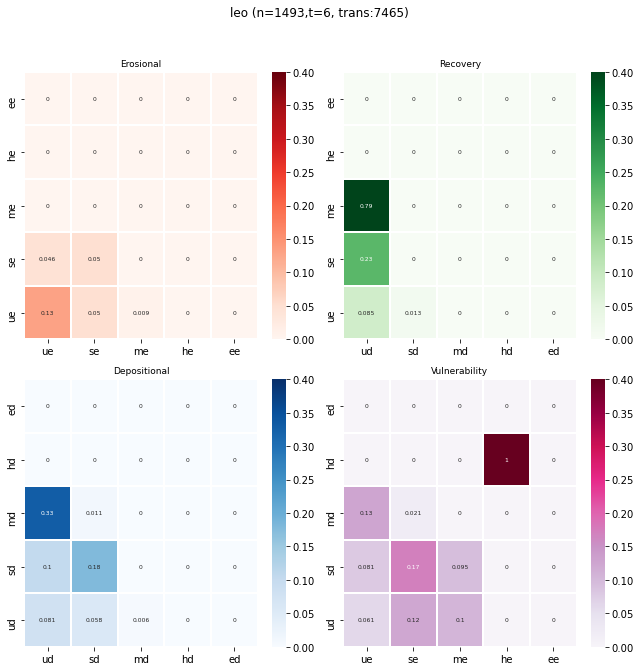

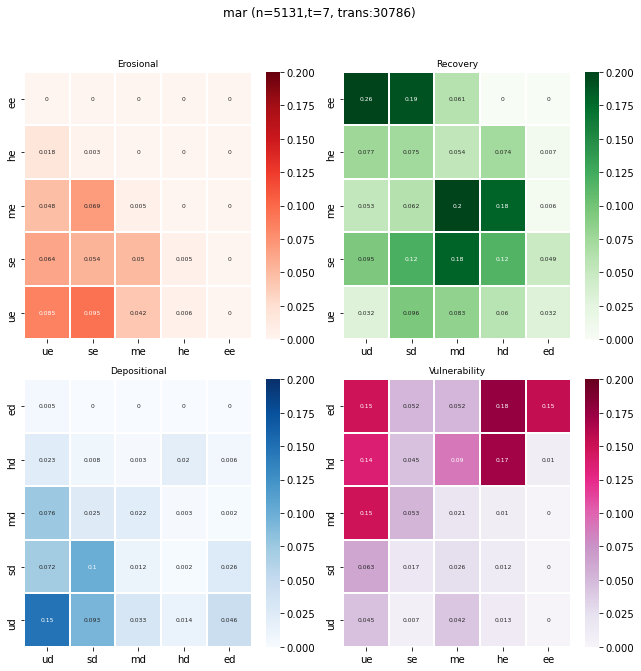

In [8]:
%%time
# For all the locations, compute e-BCD indices and Steady-States at the location level.

e_bcds,ss = BCDs_compute(dataset, weights_dict=weights_dict,
                         mode='all',
                         plot_it=True, unique_field="geometry", label_order=label_order,
                        save_it=False,fig_size=(9, 9),
                         save_output=None)


### Observations

__The title__ informs about:
* mar/leo = Location codes (leo = St. Leonards; mar = Marengo
* n = Total number of points in the timeseries (valid and non-valid)
* t = Total number of timesteps
* trans = Total number of valid transitions considered

__leo__
>We chose St. Leonards as an example to demonstrates a few limitations, which are observable in this matrix.

St. Leonards is located within Port Phillip bay. This narrrow beach is not embayed, but __fetch-limited__, meaning that it doesn't receive the highly energetic Souther Ocean swell, rather, it sees its morphodynamics impacted by considerably lower waves which are locally generated from within the bay. Moreover, seagrass meadows and reefs further reduce wave imapcts on the subaerial beachface.<br>
Therefore, __changes are small__ and often below the limit of detections, thus, uncertain. If we consider that we filter points based on (1) only sand, (2) limit of detection, (3) spatial outliers, from an already narrow beach (short transects) this location is severly decimated in terms of behavioural modelling potential.<br>

In fact, the submatrices have many zeroes, which indicate a zero probability of these transitions, because these have not been recorded.<br>
Moreover, we note how most of the transitions tend to be __from lower magnitude classes to low magnitude classes.__
<br>
Another story for Marengo.

__mar__

Marengo is an open-ocean beach with a small southern section pretected by a small headland (tombolo-like). The section used for this example is also affected by sand nourishment, which injects considerable amount of sediment during the monitoring period.<br>
Given in Marengo we have roughly 4 times the number of valid observations (trans=30'786) as compared to St. Leonards (trans=7'465), the submatrices better capture the stochastic behaviour of this beachface.



### Plotting the e-BCDs

Let's plot the e-BCDs, which summarise the information contained in the submatrices.

In [9]:
# here I translate the submatrix codes into the names and store them in a column

titles=["Erosional", "Recovery", "Depositional","Vulnerability"]

translation=dict(zip(["ee","ed","dd","de"],titles))
e_bcds["states_labels"]=e_bcds["sub_matrix"].map(translation)

e_bcds.query("location=='leo'")

,location,sub_matrix,coastal_markov_idx,trend,sign,states_labels
4,leo,de,1.786,0.467,+,Vulnerability
5,leo,dd,0.769,-0.004,-,Depositional
6,leo,ed,1.110,-0.036,-,Recovery
7,leo,ee,0.286,0.005,+,Erosional


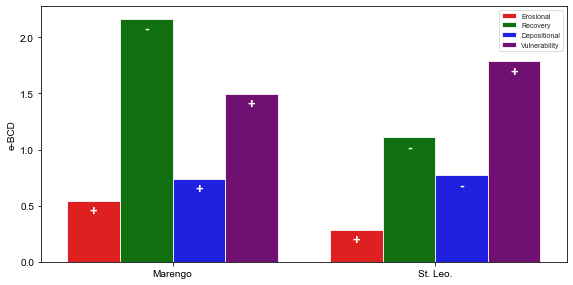

In [10]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

f,ax=plt.subplots(figsize=(8,4))

sb.set_context("paper", font_scale=0.8)
sb.set_style("whitegrid")

loc_order=["mar","leo"]

palette_dyn_states ={"Erosional":"r","Recovery":"g","Depositional":"b","Vulnerability":"purple"}
orders=["Erosional","Recovery","Depositional","Vulnerability"]

plot_bars=sb.barplot(data=e_bcds,x="location", y=e_bcds.coastal_markov_idx,hue="states_labels", hue_order=orders,
          order=loc_order, palette=palette_dyn_states)


ax.set_xticklabels(labels=["Marengo","St. Leo."])
ax.set_xlabel("")
ax.set_ylabel("e-BCD")


txt_heights=[i.get_height() for i in ax.patches]

signs=[]
for i in orders:
    for j in loc_order:
        sign=e_bcds.query(f"location == '{j}' & states_labels=='{i}'").sign.values
        signs.append(sign)
        

for p,txt_height,sign in zip(ax.patches,txt_heights,signs):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2,
         txt_height - 0.095, 
         sign[0], 
         horizontalalignment='center', 
         verticalalignment='center',
            color="white",
           fontsize=13,
           fontweight='heavy')
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc=0)

plt.tight_layout()

#f.savefig(r'E:\\path\\to\\save\\picture.png', dpi=600); 

## Residual Beachface Cluster Dynamics (r-BCD)

We already computed the __Steady State__ probability vectors for each location using the __BCDs_compute__ function, storing it in the __ss__ variable.<br>
Here below we reorder the data and plot as an heatmap, where each columns is a location and each row a magnitude of change.


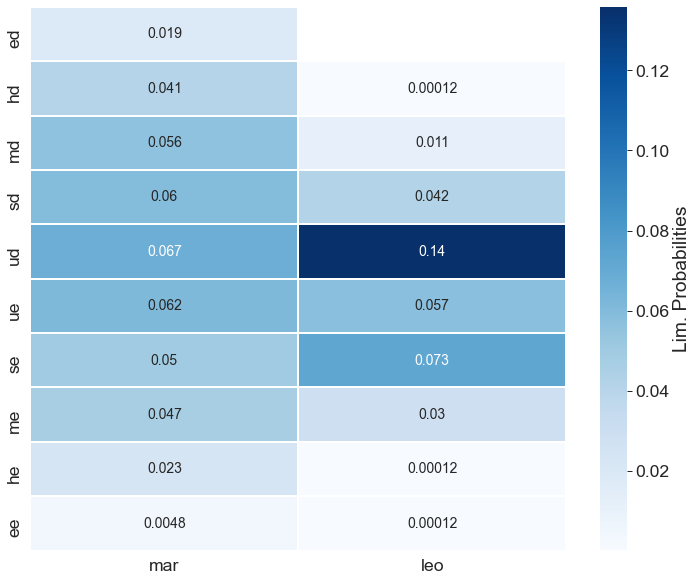

In [11]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2)

ss_victoria_ordered=ss.loc[label_order,loc_order]
ss_victoria_ordered.drop("nnn",inplace=True)
ss_victoria_ordered

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2)


f,ax=plt.subplots(figsize=(12,10))

sb.heatmap(ss_victoria_ordered, cmap="Blues",annot=True,
           annot_kws={'size':14},linewidths=1,linecolor="white", cbar_kws={'label': 'Lim. Probabilities'});

#f.savefig(r'E:\\path\\to\\save\\picture.png', dpi=600); 

### Computing the r-BCDs

The residual is simply the difference between erosional and depositional probabilities in the Steady-State distribution, __multiplicated by 100__ for readability purposes. Note that in this case, no weigths are applied as no transition is represented.


Here below, the dataframe returns the residual column, which is what you might want to map in Qgis.

In [12]:
# No weight are needed for the r-BCD index. Thus, we set a weigth dictionary of 1 (FUNCTION TO BE UPDATED).

weights_dict={"ee":1,"ed":1,
        "he":1,"hd":1,
        "me":1,"md":1,
        "se":1,"sd":1,
        "ue":1,"ud":1}

weigths_series=pd.Series(weights_dict,weights_dict.keys(), name="weight" )


# Apply the weights (USELESS, to UPDATE)
steady_state_victoria_ordered_w=ss_victoria_ordered.join(weigths_series, how="inner")
weighted_matrix=steady_state_victoria_ordered_w.iloc[:,:-1].multiply(steady_state_victoria_ordered_w.weight, axis="index")

# Create erosion and deposition sub-matrix
erosion=weighted_matrix.iloc[5:,:].transpose()
erosion["erosion"]=erosion.sum(axis=1)

deposition=weighted_matrix.iloc[:-5,:].transpose()
deposition["deposition"]=deposition.sum(axis=1)

# Compute erosion residuals
indexes_vic=(deposition.deposition -erosion.erosion) * 100    # to make the indexes more readable
indexes_vic=pd.DataFrame(pd.Series(indexes_vic, name="residual"))
indexes_vic.reset_index(inplace=True)
indexes_vic.rename({"index":"location"},axis=1, inplace=True)

# Put all into one table
deposition["erosion"]=erosion.erosion
to_plot=deposition.reset_index()[["index","deposition","erosion"]].rename({"index":"location"},axis=1)

to_print_table=to_plot.merge(indexes_vic, on="location", how="left")
to_plot=to_print_table.melt(id_vars=["location"],var_name="process",value_name="coastal_index")


to_print_table

,location,deposition,erosion,residual
0,mar,0.243289,0.186929,5.635999
1,leo,0.189379,0.160689,2.869018


The above table, the column __residual__ represent the r-BCD index for the locations, which we also call __behavioural regime__.

___

### GOOD!

Location level BCDs are good to compare multiple locations across wide areas. But what about getting a more detailed spatial-explicit view of the behaviour of a beachface system, at the transect-level?

Continue to the next notebook: __Example 5b - Beachface Cluster Dynamics indices - Transect level__